In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
bankData = pd.read_csv('banking.csv')
bankData.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1


Input variables:

1. age (numeric)
2. job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
3. marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
4. education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
5. (none)default: has credit in default? (categorical: “no”, “yes”, “unknown”)
6. housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
7. loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
8. (none)contact: contact communication type (categorical: “cellular”, “telephone”)
9. month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
10. day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)
16. emp.var.rate: employment variation rate — (numeric)
17. cons.price.idx: consumer price index — (numeric)
18. cons.conf.idx: consumer confidence index — (numeric)
19. euribor3m: euribor 3 month rate — (numeric)
20. nr.employed: number of employees — (numeric)


Predict variable (desired target):

y — has the client subscribed a term deposit? (binary: “1”, means “Yes”, “0” means “No”)

#### Reduce the categories of the education column:

In [3]:
bankData['education']=np.where(bankData['education'] =='basic.9y', 'Basic', bankData['education'])
bankData['education']=np.where(bankData['education'] =='basic.6y', 'Basic', bankData['education'])
bankData['education']=np.where(bankData['education'] =='basic.4y', 'Basic', bankData['education'])

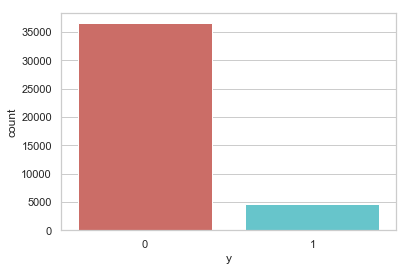

<Figure size 432x288 with 0 Axes>

In [4]:
sns.countplot(x='y',data=bankData,palette='hls')
plt.show()
plt.savefig('count_plot')

#### Our classes are imbalanced, and the ratio of no-subscription to subscription instances is aroud 9:1. Before we go ahead to balance the classes, let’s do some more exploration.

In [5]:
bankData.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn’t.
The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.
We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

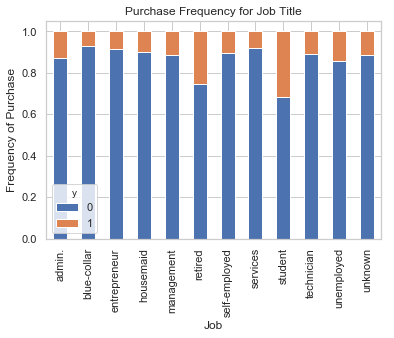

In [6]:
%matplotlib inline
table=pd.crosstab(bankData.job,bankData.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

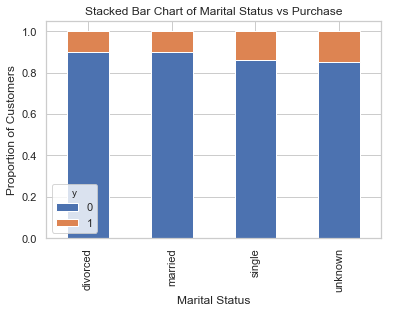

In [7]:
table=pd.crosstab(bankData.marital,bankData.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

The marital status does not seem a strong predictor for the outcome variable.

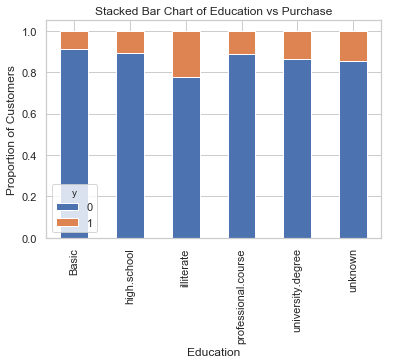

In [8]:
table=pd.crosstab(bankData.education,bankData.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

Education seems a good predictor of the outcome variable.

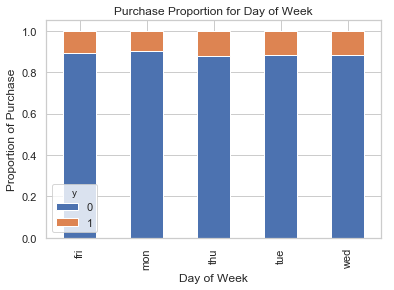

In [9]:
#pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
table=pd.crosstab(bankData.day_of_week,bankData.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Proportion for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Proportion of Purchase')
plt.savefig('pur_dayofweek_bar')

Day of week may not be a good predictor of the outcome.

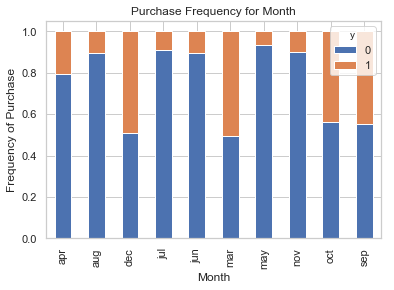

In [10]:
table=pd.crosstab(bankData.month,bankData.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

Month might be a good predictor of the outcome variable.

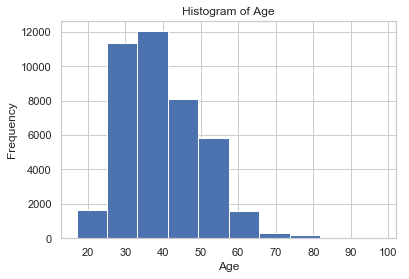

In [11]:
bankData.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

Most of the customers of the bank in this dataset are in the age range of 30–40.

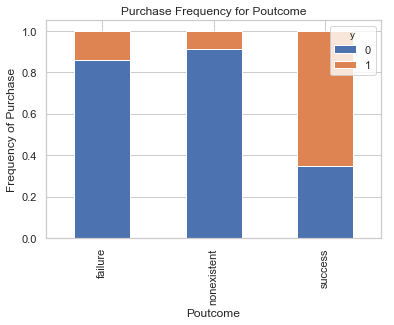

In [12]:
table=pd.crosstab(bankData.poutcome,bankData.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

Poutcome seems to be a good predictor of the outcome variable.

## then we convert categorical data in to numeric data(0,1)

In [13]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(bankData[var], prefix=var)
    dummy=bankData.join(cat_list)
    bankData=dummy

data_vars=bankData.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [14]:
bank_final=bankData[to_keep]
bank_final.head(3)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0,0,0,0,1,0,0,0,1,0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,0,0,1,0,0,0,0,0,1,0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0,0,0,0,1,0,0,0,0,1


### Over-sampling using SMOTE
With our training data created, I’ll up-sample the no-subscription using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:

1. Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [15]:
X = bank_final.loc[:, bank_final.columns != 'y']
y = bank_final.loc[:, bank_final.columns == 'y']

from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_use, X_keep, y_use, y_keep = train_test_split(X, y, test_size=0.3, random_state=10)

columns = X_use.columns
os_data_X,os_data_y=os.fit_sample(X_use, y_use)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

# We can check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  51232
Number of no subscription in oversampled data 25616
Number of subscription 25616
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

### Recursive Feature Elimination
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [16]:
bank_final_vars=bank_final.columns.values.tolist()
X=[i for i in bank_final_vars if i!='y']

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(solver = "liblinear",max_iter = 1000)
rfe = RFE(logreg, 20)  # where you set number of variables to choose
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
#print(rfe.ranking_)

In [17]:
cols = [var for i,var in enumerate(list(os_data_X.columns)) if rfe.support_[i]][0:8] # where select how many features to use
X = os_data_X[cols]
y = os_data_y['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X.head()

,previous,emp_var_rate,job_blue-collar,job_housemaid,job_management,job_self-employed,job_services,job_technician
0,0.0,1.1,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-3.4,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.1,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,-1.8,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    m = y_predict.shape[0]
    avg = np.average(y_predict)
    return np.average(np.power((avg-y),2))

In [19]:
def variance(y_predict,y):
    y_predict = np.array(y_predict)
    return np.var(y_predict)

In [20]:
X.reindex(index=range(X.shape[0]));
y.reindex(index=range(y.shape[0]));

In [21]:
from sklearn.model_selection import KFold

def hyperparameter(X, y, penal, K):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []    
    best = {'train':0,'test':0,'model':None,'param':None}
    for param in np.logspace(-5,1.0,60):
        kf = KFold(n_splits=K)
        kf.get_n_splits(X)
        param_keep = []
        
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            clf = LogisticRegression(C=param, solver="liblinear", penalty=penal).fit(X_train, y_train)
            y_train_predict = clf.predict(X_train)
            y_test_predict = clf.predict(X_test)

            train_accuracy = accuracy_score(y_train, y_train_predict)
            test_accuracy = accuracy_score(y_test, y_test_predict)
            scores = clf.predict_proba(X_train)

            bia = bias(y_train_predict,y_train)
            var = variance(scores,y_train)
            total = bia + var
            param_keep.append((train_accuracy, test_accuracy, bia, var,total))

        result_list.append((param, sum([i[0] for i in param_keep])/K, sum([i[1] for i in param_keep])/K,\
                            sum([i[2] for i in param_keep])/K, sum([i[3] for i in param_keep])/K, sum([i[4] for i in param_keep])/K ))
        if result_list[-1][2]>best['test']:
            best['train'] = result_list[-1][1]
            best['test'] = result_list[-1][2]
            best['model'] = clf
            best['param'] = param    
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy", "bia", "var","total"])    
    return result_df, best

## training using k-fold cross-validation, to see the relationship between accuracy and L1 regulation
### x-axis is weight of L1 regularization, indicate how "strong" L1 regularzation is

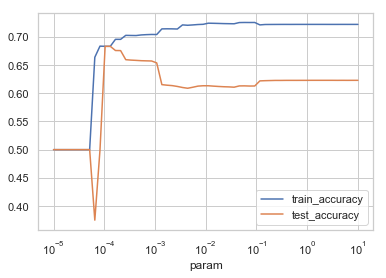

In [22]:
param_df_l1, best_model = hyperparameter(X, y,'l1',4)
param_df_l1.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

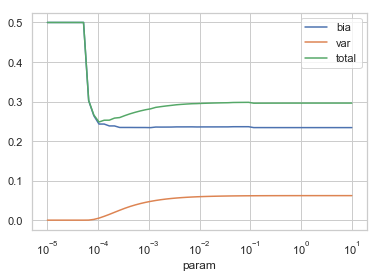

In [23]:
param_df_l1.plot(x="param", y=["bia", "var", "total"], logx=True)

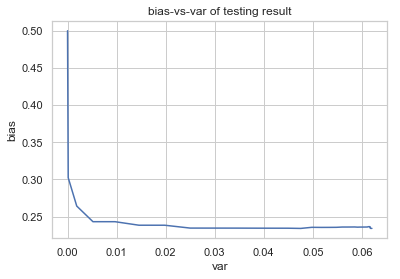

In [24]:
x_ = param_df_l1.loc[:,'var']
y_ = param_df_l1.loc[:,'bia']
plt.plot(x_,y_)
plt.title('bias-vs-var of testing result')
plt.xlabel('var')
plt.ylabel('bias')
plt.show
plt.savefig('bias-vs-var')

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

def plot_roc(true, score):
    preds = score[:,1]
    fpr, tpr, threshold = roc_curve(true, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)

    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

ROC plot and corresponding AUC:

Precision score: 0.6583352708672402
Recall score: 0.7412303664921466
F1 Score: 0.6973279152813693


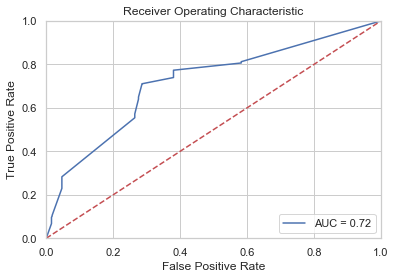

In [26]:
test_score = best_model['model'].predict_proba(X_test)
print('ROC plot and corresponding AUC:\n')
plot_roc(y_test,test_score)

y_test_predict = best_model['model'].predict(X_test)

from sklearn.metrics import precision_score
print("Precision score: {}".format(precision_score(y_test,y_test_predict)))
from sklearn.metrics import recall_score
print("Recall score: {}".format(recall_score(y_test,y_test_predict)))
from sklearn.metrics import f1_score
print("F1 Score: {}".format(f1_score(y_test,y_test_predict)))

# Compute bias-variance-tradeoff with tensorflow

In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt
def minibatch(inputdata,label,batchsize):
    index = np.arange(inputdata.shape[0],dtype = np.int)
    np.random.shuffle(index)
    if inputdata.shape[0]%batchsize == 0:
        batch_num = inputdata.shape[0]//batchsize
    else:
        batch_num = inputdata.shape[0]//batchsize+1
    output_minibatch_X = []
    output_minibatch_y = []
    split_point = np.array([i*batchsize for i in range(1,batch_num)])
    batch_index = np.split(index,split_point)
    for i in batch_index:
        tmp = i.tolist()
        output_minibatch_X.append(inputdata[tmp,:])
        output_minibatch_y.append(label[tmp,:])
    return output_minibatch_X,output_minibatch_y

def to_one_hot(label):
    tmp = label*-1+1
    return np.hstack((tmp,label))
                
def logisitc_regression(input_data,
                        label,
                        batch_size,
                        lr,
                        iteration,
                        decay):
    
    train_loss_plot = []
    train_acc_plot = []
    bias_plot = []
    var_plot = []
    total_plot = []
    
    tf.reset_default_graph()
    label_one_hot = to_one_hot(label)
    
    X = tf.placeholder(tf.float32,[None,input_data.shape[1]])
    Y = tf.placeholder(tf.float32,[None,label_one_hot.shape[1]])
    
    with tf.variable_scope("logistic"):
        W = tf.get_variable("w",[input_data.shape[1],label_one_hot.shape[1]],initializer = tf.random_normal_initializer(0,0.3))
        B = tf.get_variable("b",[label_one_hot.shape[1]],initializer = tf.random_normal_initializer(0,0.3))
    
        predict = tf.add(tf.matmul(X,W),B)
        
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = predict,labels = Y)) + decay/2*tf.reduce_mean(tf.pow(W,2)) # regularization
        optimizer = tf.train.AdamOptimizer(lr).minimize(loss)
        
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y,1),tf.argmax(predict,1)),dtype = tf.float32))
        
        bias = tf.reduce_mean(tf.reduce_mean(predict)-Y)**2
        var = tf.reduce_mean(tf.pow(predict-tf.reduce_mean(predict),2))
        total = bias+var
    
    init = tf.global_variables_initializer()
        
    with tf.Session() as sess:
        sess.run(init)
        for i in range(iteration):
            minibatch_x,minibatch_y = minibatch(input_data,label_one_hot,batch_size)
            for j in range(len(minibatch_x)):
                model_input_x,model_input_y = minibatch_x[j],minibatch_y[j]
                sess.run(optimizer,feed_dict={X: model_input_x,
                                              Y: model_input_y})
            loss_train_tmp,acc_train_tmp = sess.run([loss,accuracy],feed_dict={X: input_data, 
                                                                               Y: label_one_hot})
            bias_train_tmp,var_train_tmp,total_train_tmp = sess.run([bias,var,total],feed_dict={X: input_data,
                                                                                                Y: label_one_hot})
            train_loss_plot.append(loss_train_tmp)
            train_acc_plot.append(acc_train_tmp)
            bias_plot.append(bias_train_tmp)
            var_plot.append(var_train_tmp)
            total_plot.append(total_train_tmp)
        
        acc_final = sess.run(accuracy,feed_dict = {X:input_data,
                                                   Y:label_one_hot})
        
    # plot
    xxx = np.linspace(1,iteration,iteration,dtype = np.int16)
    
    plt.figure(figsize=[10,7],dpi=300)
    ax1 = plt.subplot()
    plt.title("Cross Entrpy Loss on Logistic Regression Model")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    ax1.plot(xxx,train_loss_plot,'r-',label = "Training loss")
    plt.legend(loc=1,shadow=True)
    # plt.savefig('loss on tensorflow')
    plt.show()
    
    plt.figure(figsize=[10,7],dpi=300)
    ax2 = plt.subplot()
    plt.title("Training performance Logistic Regression Model")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy") 
    ax2.plot(xxx,train_acc_plot,'r-',label = "Training accuracy")
    plt.legend(loc=4,shadow=True)
    # plt.savefig('training accuracy on tensorflow')
    plt.show()
    
    
    plt.figure(figsize=[10,7],dpi=300)
    ax2 = plt.subplot()
    plt.title("Training performance Logistic Regression Model")
    plt.xlabel("Epoch")
    plt.ylabel("error") 
    ax2.plot(xxx,bias_plot,'r-',label = "bias")
    ax2.plot(xxx,var_plot,'b-',label = "var")
    ax2.plot(xxx,total_plot,'g-',label = "total error")
    plt.legend(loc=4,shadow=True)
    #plt.savefig('var bias tradoff on tensorflow')
    plt.show()
    print("final_test_acc:",acc_final)
    print("max_test_acc:",max(train_acc_plot))

In [33]:
X_tensor = X.values.astype(np.float32)
y_tensor = np.expand_dims(y.values.astype(np.float32),axis = 1)
print(X_tensor.shape,y_tensor.shape)

(51232, 8) (51232, 1)


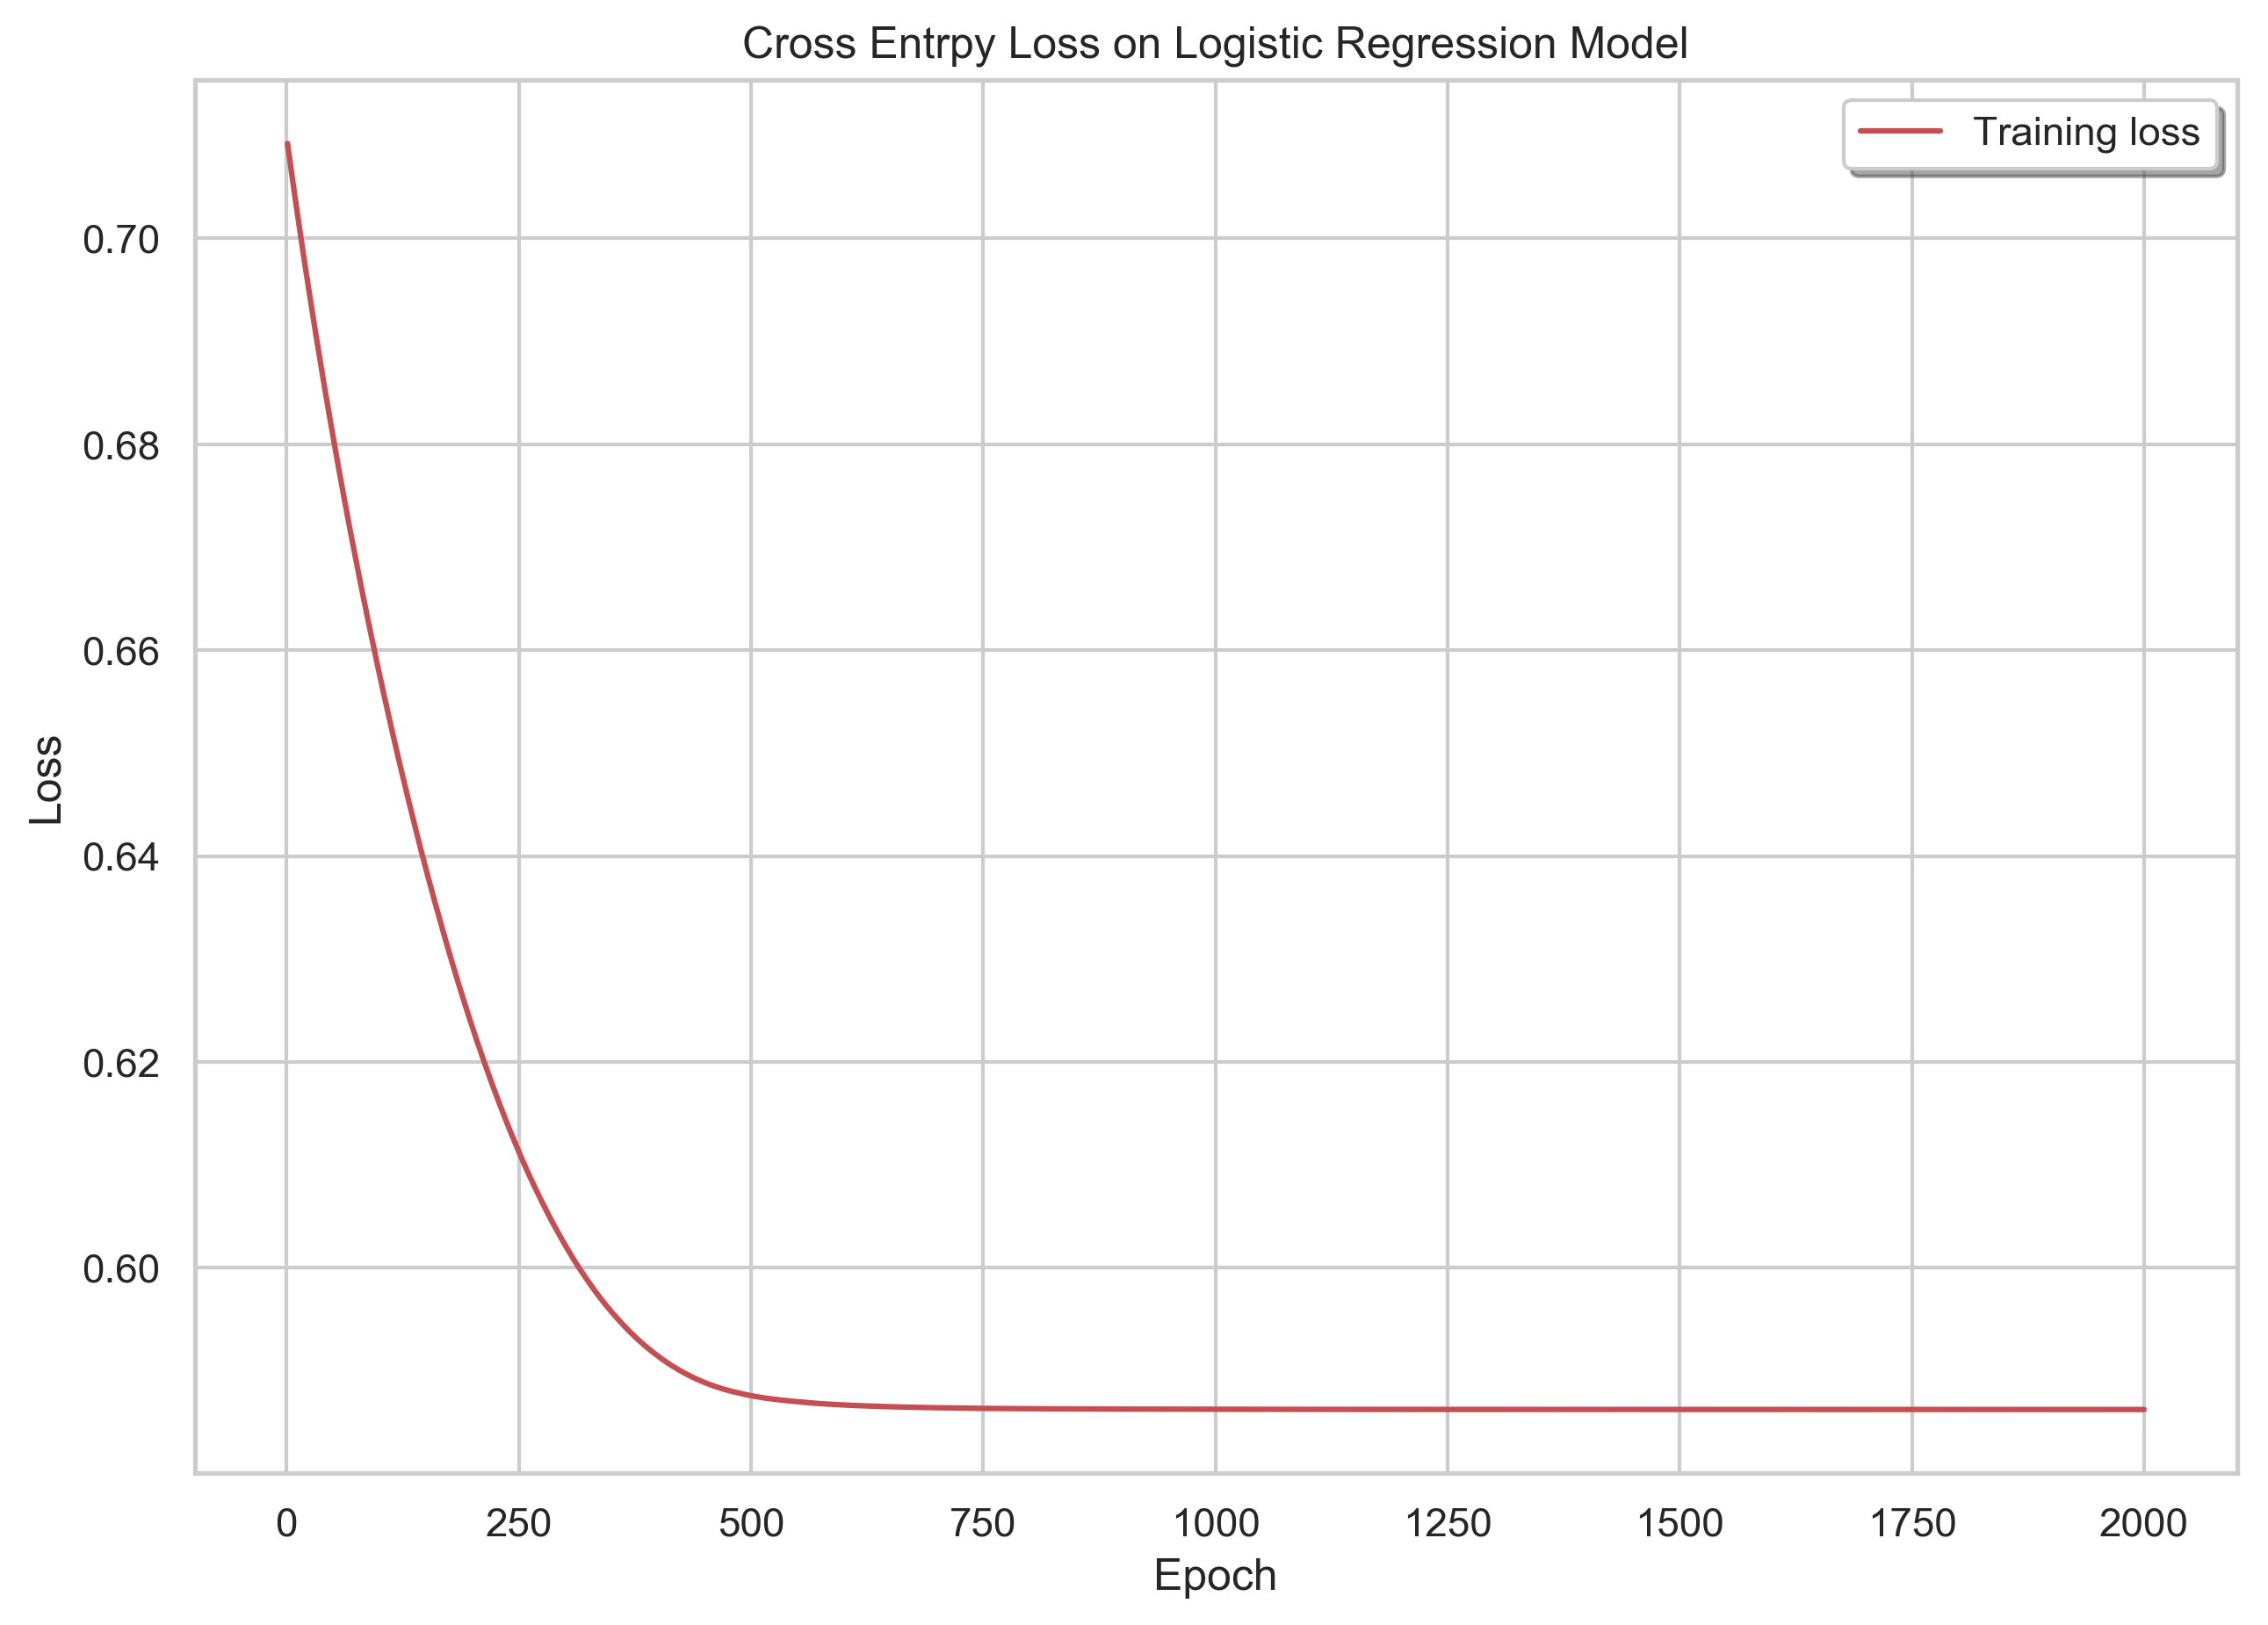

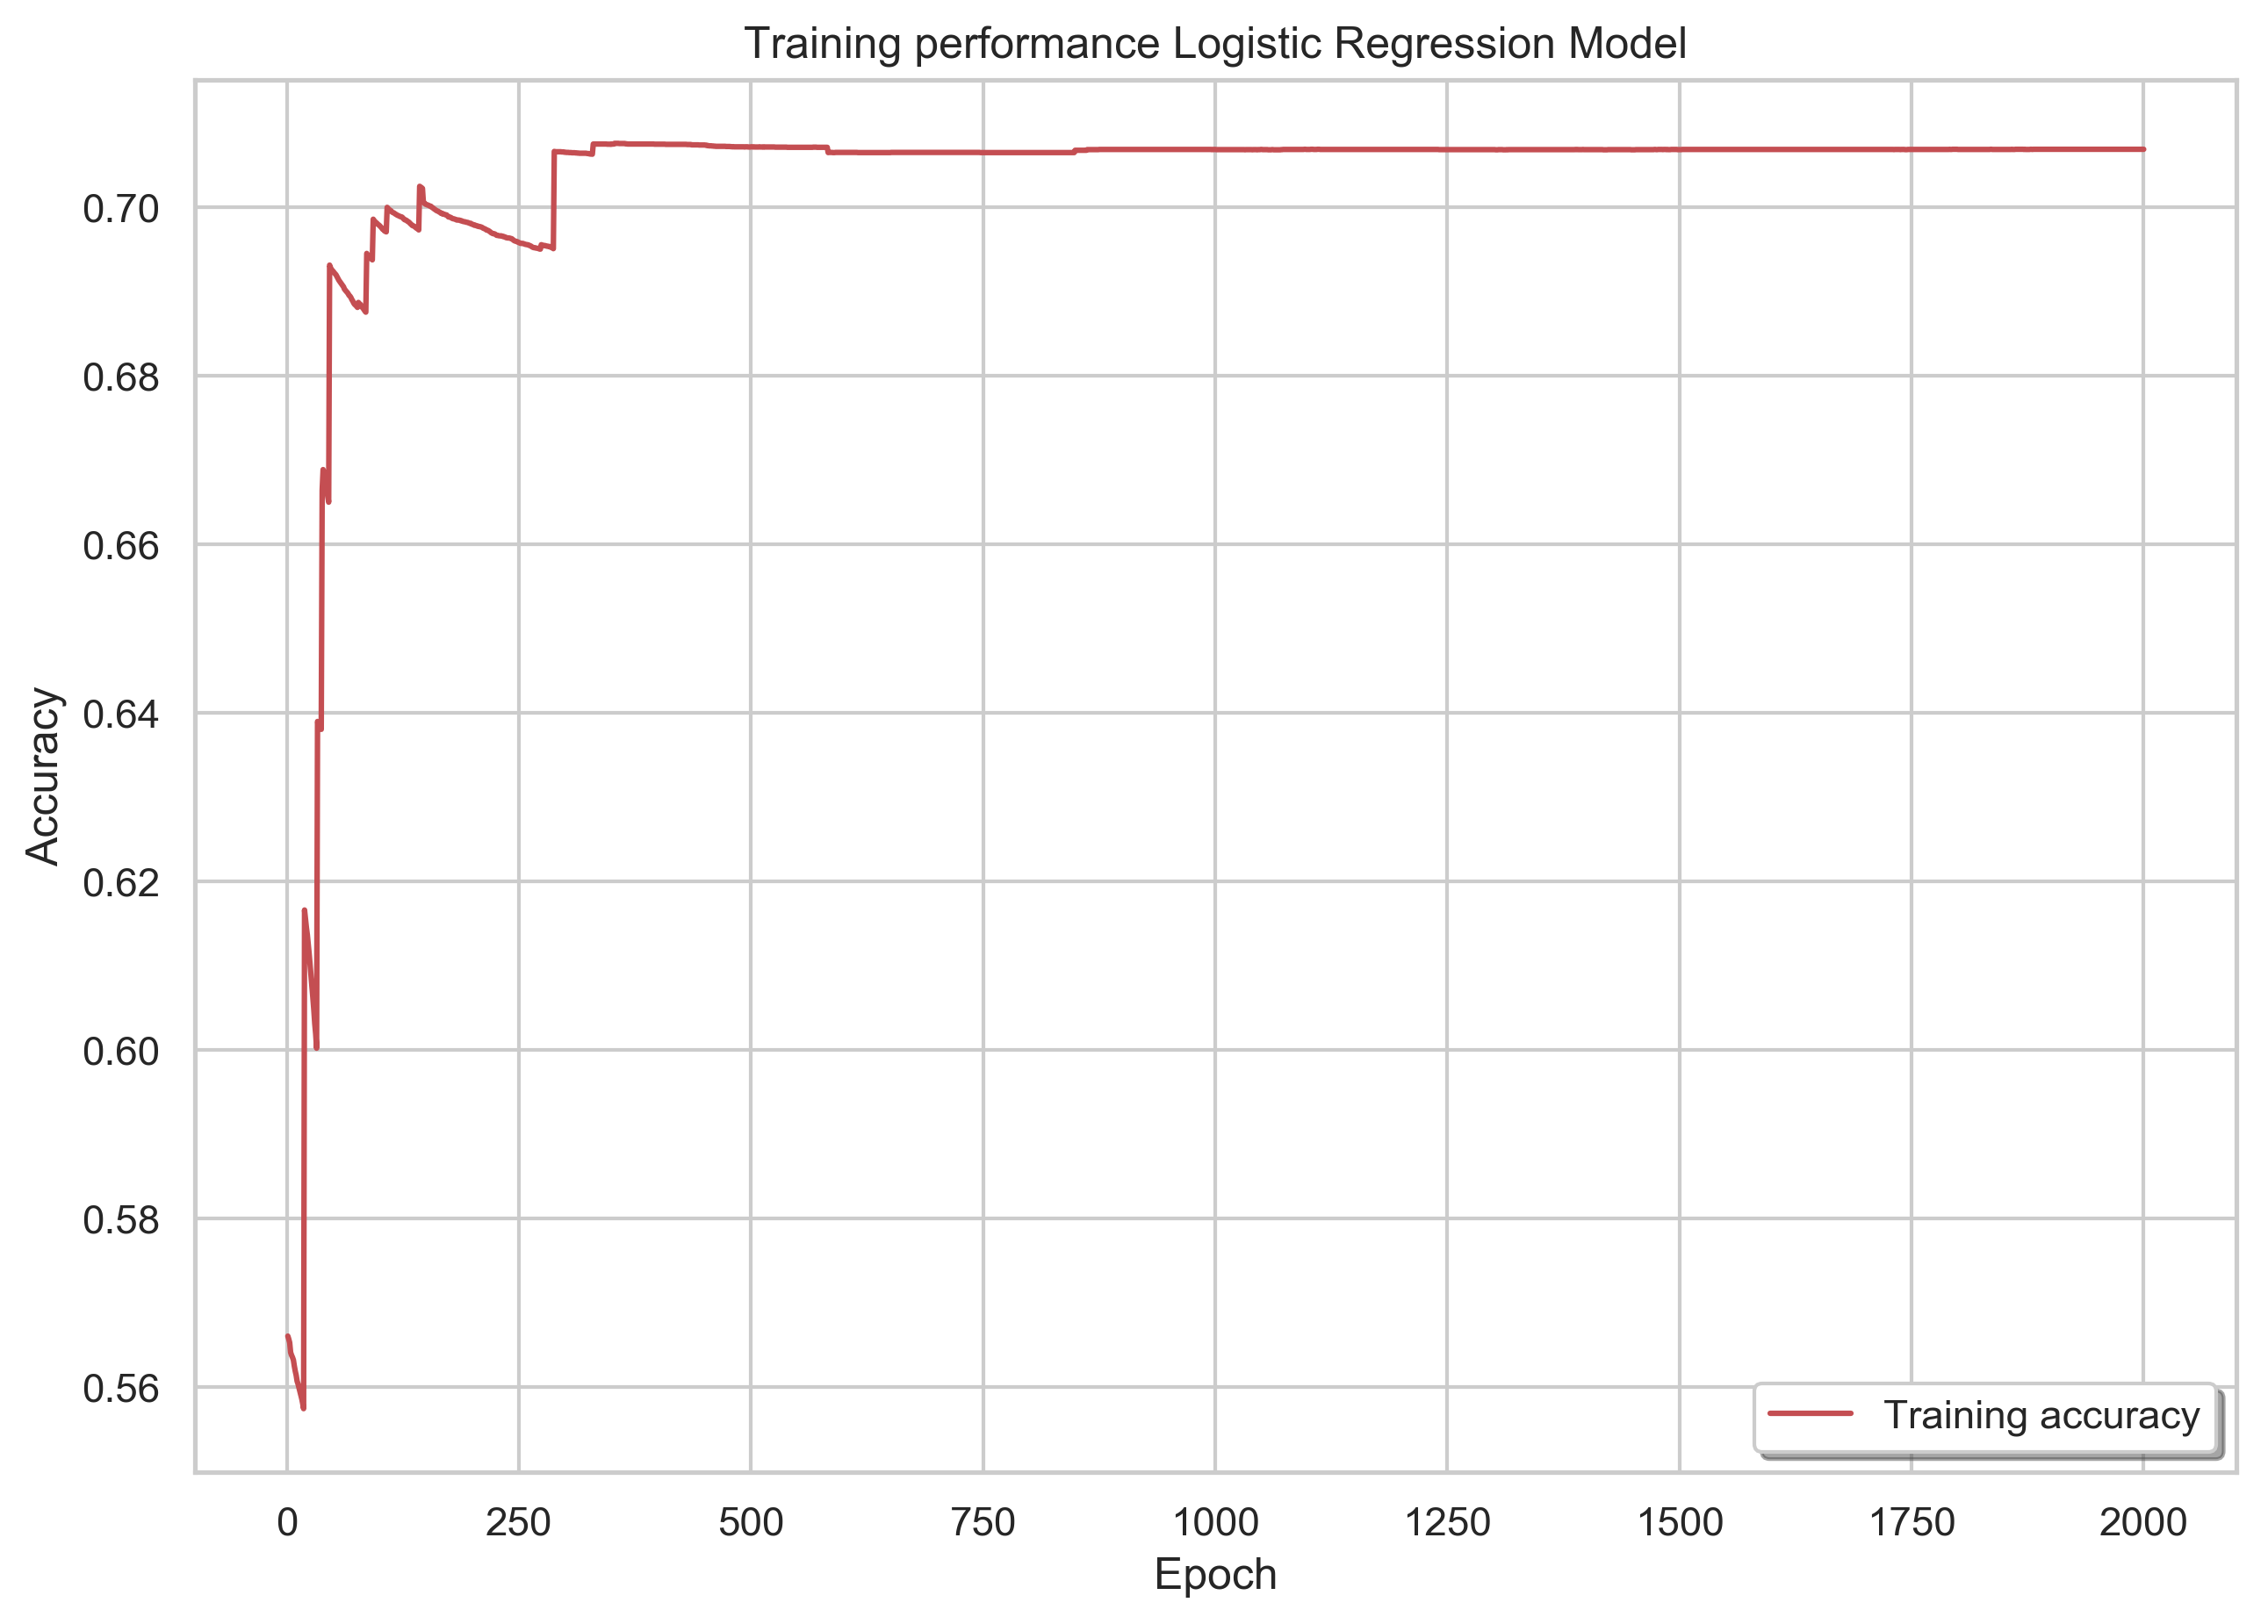

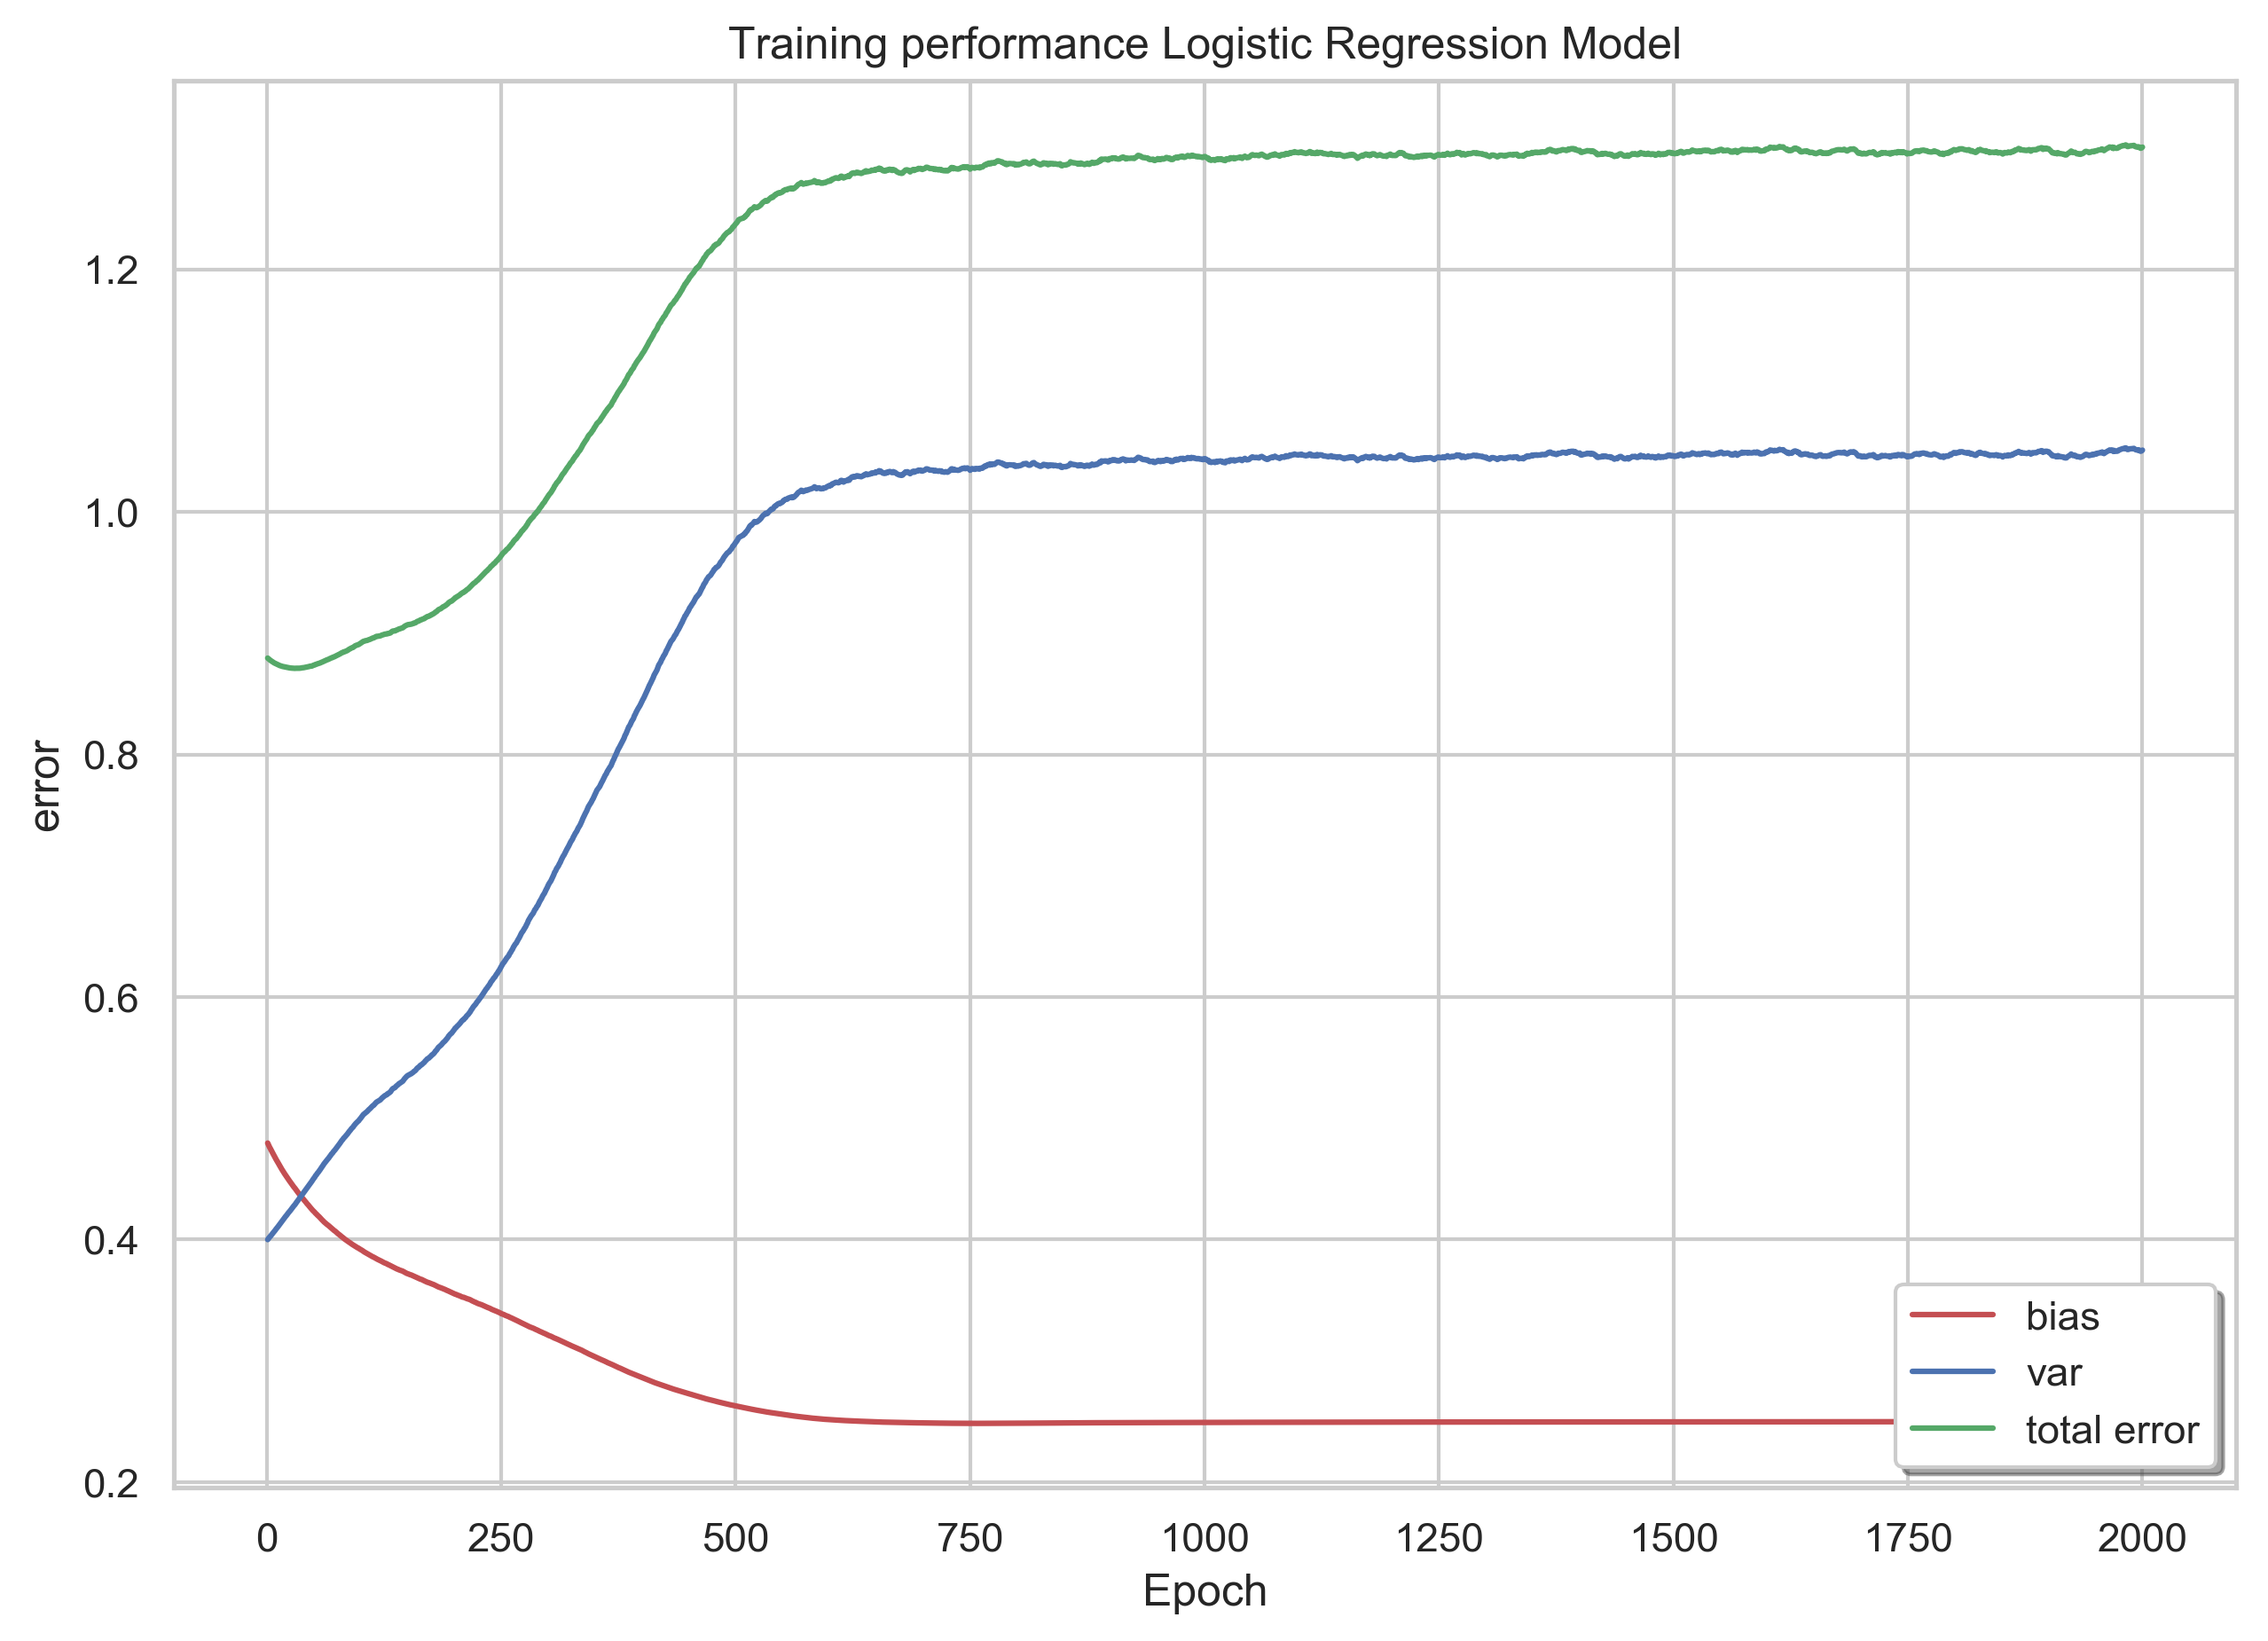

final_test_acc: 0.7068824
max_test_acc: 0.7075851


In [36]:
logisitc_regression(input_data = X_tensor,
                    label = y_tensor,
                    batch_size = 1024,
                    lr = 0.00003,
                    iteration = 2000,
                    decay = 0.0001)